In [17]:
import keepsake
import pandas as pd
import numpy as np

from validation_utils import transform_data_for_inference, line_color, downsample_df, run_inference, calculate_error, filter_df_by_signals, get_move_from_path

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

%matplotlib inline

In [18]:
keepsake.experiments.get('628e029')

Name,Value
features,"['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y']"
hz,50
f1,1
quantization,None
n_estimators,6
recall,1
accuracy,1
dataset_test_size,0.35
data_set,base
other_params,default


In [19]:
rf_2_settings = keepsake.experiments.get('628e029').params

In [20]:
from models.optimized.base.random_forest import random_forest_628e029 as rf_2 # 50hz

In [21]:
# tuple format (loaded model, hz, plot coordinates, model name, id, stage, signals/features)

model_setups = [
    (rf_2, rf_2_settings['hz'], (0,1), rf_2_settings['model'], 2,'optimized', rf_2_settings['features']),  
]

In [77]:
def debounce_threshold(freq):
    freq_mapping = {
        20: 4,
        25: 5,
        50: 10
    }
    return freq_mapping[freq]

In [78]:
def run_validation_debounce(model_setups, dataset_path, time_diff):
    fig, ax = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(24,7))

    df_val = pd.read_csv(dataset_path).set_index('ms')

    for setup in model_setups:
        MODEL = setup[0]
        FREQ = setup[1]
        SIGNALS = setup[-1]
        STEP = (1000 / FREQ)

        inf_results = pd.DataFrame([],columns=['start','end','result'])

        df_downsampled = downsample_df(df_val, period=STEP)
        df_filtered = filter_df_by_signals(df_downsampled, SIGNALS)
        df_inference = transform_data_for_inference(df_filtered)

        ax[0].plot(df_filtered)
        ax[1].plot(df_filtered)

        inference_step = list(np.arange(0, df_val.index[-1] + 1 - 1010, step=STEP))

        inf_list = []

        for st in inference_step:
            res = np.argmax(run_inference(df_inference, MODEL, st, STEP))
            inf_results = pd.concat([inf_results, pd.DataFrame([{'start':st,'end':st+1000,'result':res}])], axis=0)

            if res in [1,2,3]:
                inf_list.append((st, res))
                color = line_color(res)
                ax[0].axvline(x=st+500, ymin=0, ymax=0.3, color=color, alpha=0.4)

                
            if (len(inf_list) >= debounce_threshold(FREQ)
                and (inf_list[-1][0] - inf_list[0][0]) >= time_diff):
                
                inferences = [x[1] for x in inf_list[:debounce_threshold(FREQ)]]
                
                inference_final = max(set(inferences), key=inferences.count)
                time = inf_list[4][0] 
                
                color = line_color(inference_final)
                ax[1].axvline(x=time+500, ymin=0, ymax=0.3, color=color, alpha=0.4)
                inf_list = []

            # if len(inf_list) > 0 and (st - inf_list[0][0]) >= 1_500:
            #     inf_list = []

        blue_patch = mpatches.Patch(color='blue', label='X Movement')
        red_patch = mpatches.Patch(color='red', label='Y Movement')
        green_patch = mpatches.Patch(color='green', label='Circle Movement')
        fig.legend(handles=[blue_patch, red_patch, green_patch])

    ax[0].title.set_text('Raw inference - y\n')
    ax[1].title.set_text('Debounced inference - y\n')

    ax[0].set_xlabel('Time [ms]')
    ax[1].set_xlabel('Time [ms]')

    ax[0].set_ylabel('Acceleration [m/s^2]   /   Ang. velocity [deg/s]')

    fig.tight_layout();

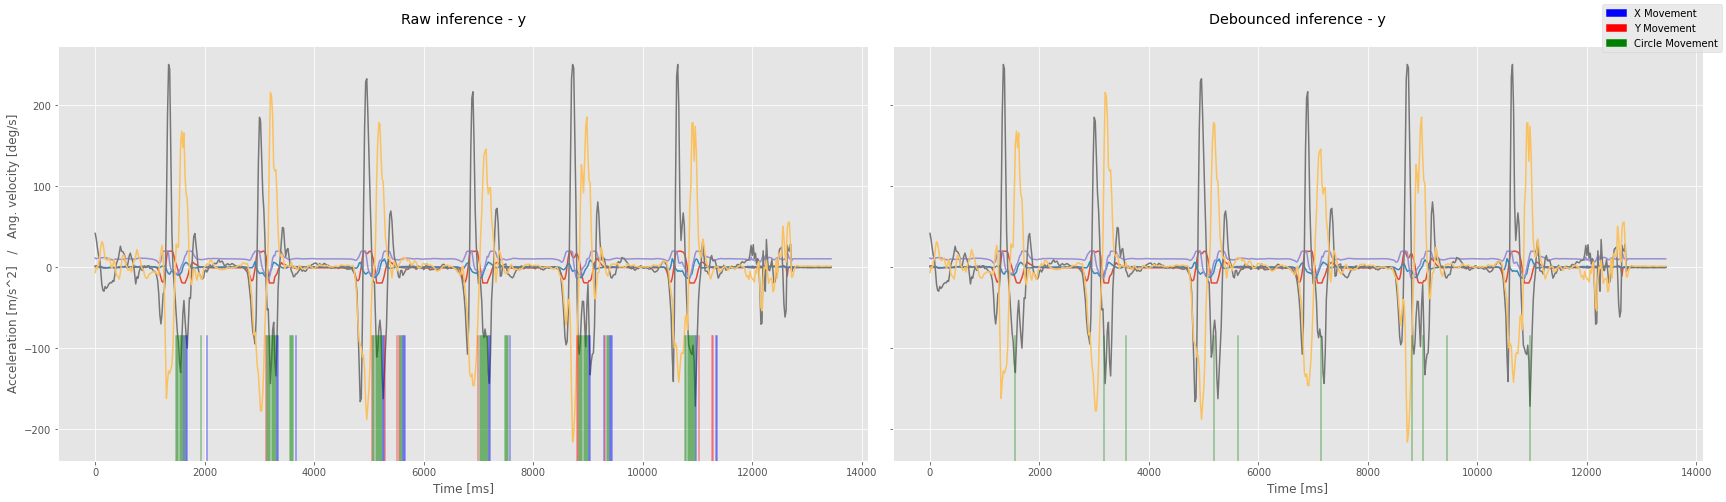

In [79]:
run_validation_debounce(model_setups, 'data/validation/move_circle_20210522_1.csv', 400)

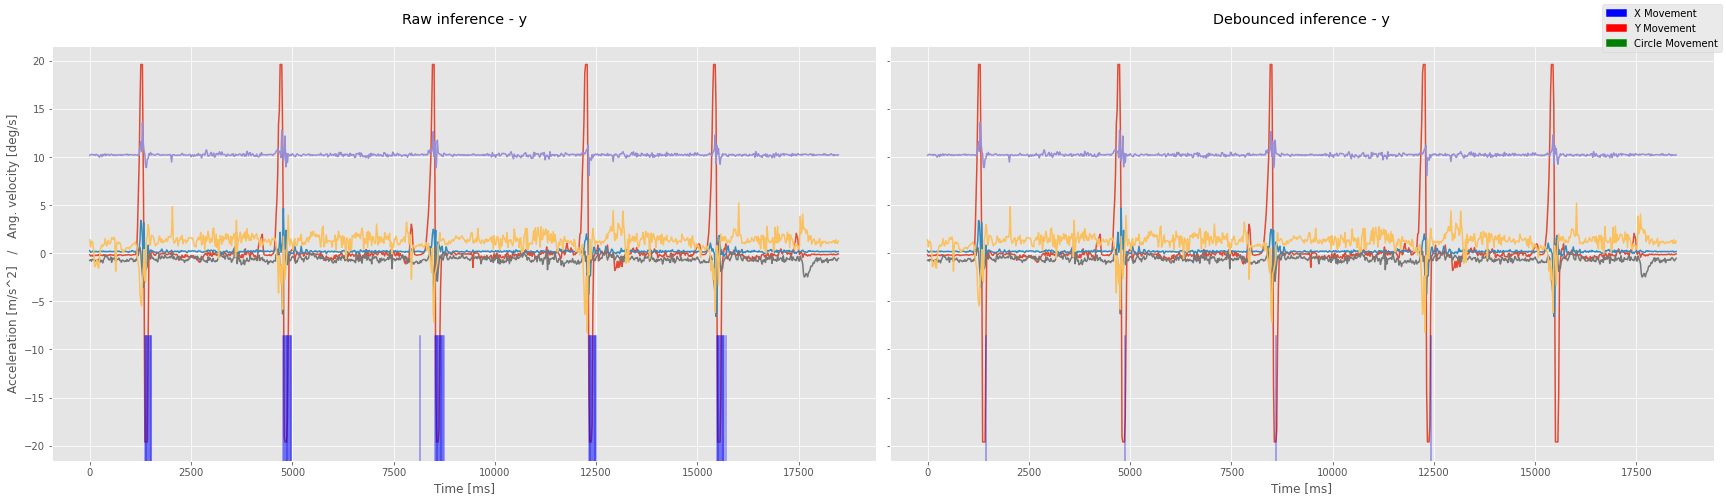

In [80]:
run_validation_debounce(model_setups, 'data/validation/move_x_20210522_1.csv', 400)

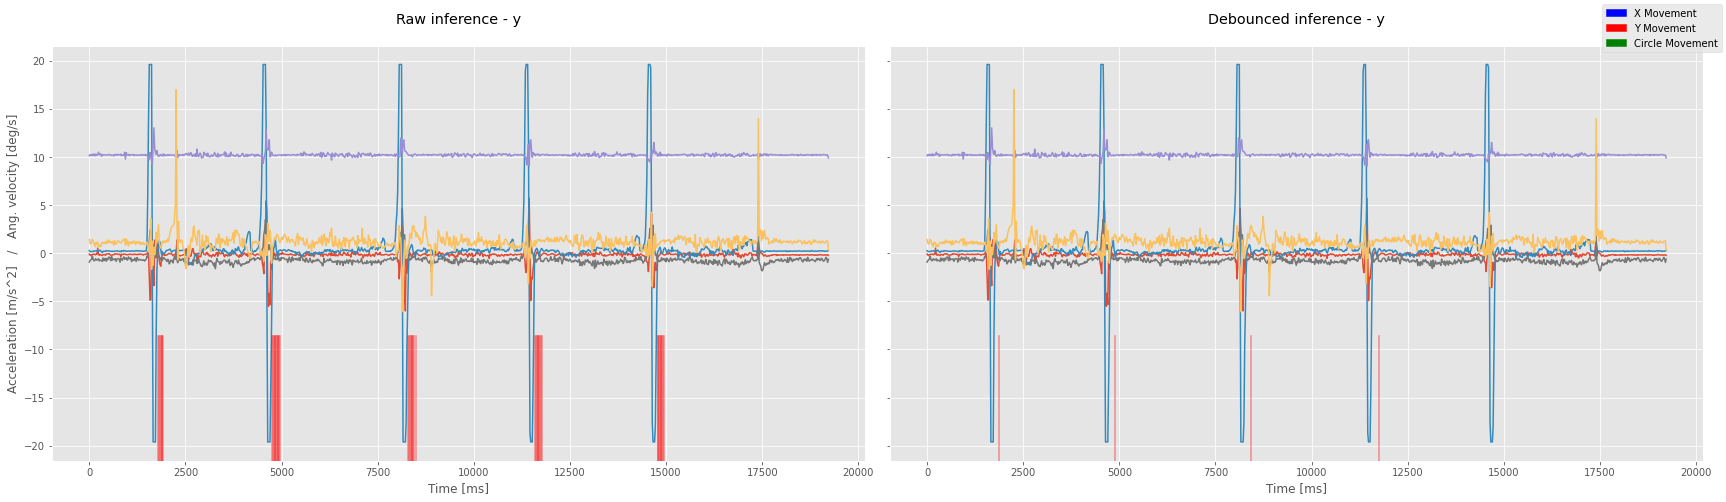

In [81]:
run_validation_debounce(model_setups, 'data/validation/move_y_20210522_1.csv', 400)